<a href="https://colab.research.google.com/github/mahin-arvind/FaceEmotionRecognition/blob/main/Face_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**INTRODUCTION**
Face emotion recognition technology detects emotions and mood patterns invoked in human faces. This technology is used as a sentiment analysis tool to identify the six universal expressions, namely, happiness, sadness, anger, surprise, fear and disgust.
Identifying facial expressions has a wide range of applications in human social interaction detection for industries like digital learning and market research. 
In this project, the Face Emotion Recognition 2013 Dataset was used to train five different types of architectures built using convolutional layers. Three custom convolutional networks were designed using traditional convolutional layers, VGG blocks and  a simple inception block. Apart from this, transfer learning was administered on VGG-16 and ResNet-50 architectures using ImageNet weights. 
A sum total of five models were trained and evaluated during the course of the project. The best-performing model was deployed as a Streamlit application to perform real-time emotion recognition.


#**PROBLEM STATEMENT**
In this project, we’ll be using the  Face Emotion Recognition 2013 dataset to
1. Effectively identify student emotions using minimum reference images,
2. Perform face emotion recognition on a webcam video feed in real-time,
3.  Create a web application to access the model and
4.  Deploy model on the cloud as an end-to-end solution.



####**IMPORTING REQUIRED LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
import keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

In [ ]:
import os, shutil, pathlib

In [ ]:
! pip install -q kaggle

In [ ]:
 ! mkdir ~/.kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahinarvindc","key":"50faa60b6bb3d64ed9fecd8c814deded"}'}

####**INSTALLING FACE EMOTION RECOGNITION 2013 DATASET from KAGGLE API**

The FER-2013 dataset was created by gathering the results of a Google image search of each emotion and synonyms of the emotions This dataset consists of 22,965 labelled images in the training set, and 5,741 labelled images in the validation set while 7,178 images were used as the test set for evaluation.

Each image in FER-2013 is labelled as one of seven emotions: happy, sad, angry, afraid, surprise, disgust, and neutral, with ‘happy’ being the most prevalent emotion. The images in FER-2013 consist of both posed and unposed headshots, which are in grayscale and 48x48 pixels in dimension. 


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d ananthu017/emotion-detection-fer

 71% 46.0M/65.2M [00:00<00:00, 178MB/s]
100% 65.2M/65.2M [00:00<00:00, 214MB/s]


In [ ]:
#UNZIP
!unzip -qq emotion-detection-fer.zip

#Splitting Train into Train Set and Validation Set

In [ ]:
def minidataset(main_directory,folder_name, train_split, val_split):
  
  if train_split + val_split > 1:
    print('Split mismatch')
    return 0
  
  source_dir = f'/content/train/{folder_name}'
  train_dir = f'/content/{main_directory}/train/{folder_name}'
  val_dir = f'/content/{main_directory}/val/{folder_name}'

  folder_paths = [train_dir, val_dir]
  splits = [train_split, val_split]
  folder_names = ['train', 'val']

  file_paths = os.listdir(source_dir)
  head = 0
  tail = 0

  for i,folder_path in enumerate(folder_paths):
    tail = head + int(len(file_paths)*splits[i]) #last index of the split
    split_filepaths = file_paths[head: tail]
    head = tail #updating head value for next iteration
    os.mkdir(folder_path)
    for file_name in split_filepaths:
        shutil.move(os.path.join(source_dir, file_name), folder_path)
    
  print(f"{main_directory}/{folder_name} Created Successfully")

In [ ]:
main_directory= 'WorkingDataset'
folder_names = ['train', 'val']

os.mkdir(f'/content/{main_directory}')

for i,name in enumerate(folder_names):
  os.mkdir(f'/content/{main_directory}/{folder_names[i]}')

for folder in ['angry','disgusted','fearful','happy','neutral','sad','surprised']:

  minidataset(f"{main_directory}", f'{folder}',0.8,0.2) #splitting train into train and cvalidation 


WorkingDataset/angry Created Successfully
WorkingDataset/disgusted Created Successfully
WorkingDataset/fearful Created Successfully
WorkingDataset/happy Created Successfully
WorkingDataset/neutral Created Successfully
WorkingDataset/sad Created Successfully
WorkingDataset/surprised Created Successfully


####**IMAGE SAMPLES**

In [ ]:
pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab.patches import cv2_imshow

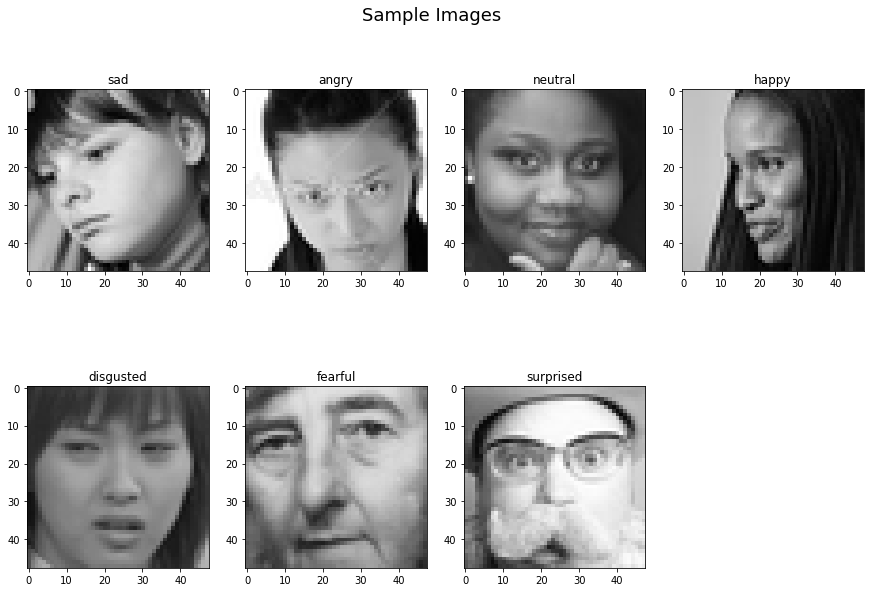

In [ ]:
plt.figure(figsize=(15, 10))
plt.suptitle("Sample Images", fontsize=18, y=0.95)

for n,dir in enumerate(os.listdir('/content/WorkingDataset/train')):
  for i in os.listdir(f'/content/WorkingDataset/train/{dir}'):
    ax = plt.subplot(2,4, n + 1)
    image = cv2.imread(f'/content/WorkingDataset/train/{dir}/{i}')
    plt.imshow(image)
    plt.title(dir)
    break


####**PREPROCESSING IMAGES**

>* **DATA AUGMENTATION**:
Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. Training deep learning neural network models on more data can result in more skilful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images.[1] The Keras deep learning neural network library has been used to perform image data augmentation via the ImageDataGenerator class.

>* Apart from augmenting images, all the image pixel values in the dataset are rescaled from the [0, 255] range to the [0,1] range



In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

picture_size = 48
folder_path = "/content/WorkingDataset/"
batch_size  = 64

datagen_train  = keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, # zoom
                                                              horizontal_flip=True, # horizontal flip
                                                              brightness_range=[0.2,1.2],
                                                              rescale = 1./255
                                                              )
datagen_val = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


val_set = datagen_val.flow_from_directory(folder_path+ 'val',
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)



test_set = datagen_val.flow_from_directory('/content/test',
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 22965 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


####**SHAPE OF IMAGE IN TRAIN, TEST and VAL dataset**

In [ ]:
for dataset in   [train_set, val_set, test_set]:
  for data_batch, labels_batch in dataset:
      print("\ndata batch shape:", data_batch.shape)
      print("labels batch shape:", labels_batch.shape)
      break


data batch shape: (64, 48, 48, 1)
labels batch shape: (64, 7)

data batch shape: (64, 48, 48, 1)
labels batch shape: (64, 7)

data batch shape: (64, 48, 48, 1)
labels batch shape: (64, 7)


####**FUNCTION TO UPDATE REPORTS**

Precision, Recall, F1 score and Balanced Accuracy are the metrics used to evaluate and compare models using the test dataset

In [ ]:
from keras.models import load_model
from sklearn.metrics import recall_score, precision_score, confusion_matrix, f1_score, balanced_accuracy_score

report = {
    'model_name':[],
    'recall': [],
    'precision': [],
    'f1': [],
    'balanced_accuracy': []
}
report_df = pd.DataFrame()

def update_report(model_path, model_name, test_set):

  model = load_model(model_path)
  y_preds = np.argmax(model.predict(test_set), axis=1)
  y_test = test_set.labels

  recall = recall_score(y_test, y_preds, average = 'weighted')
  precision = precision_score(y_test, y_preds, average = 'weighted')
  f1 = f1_score(y_test, y_preds, average = 'weighted')
  balanced_accuracy = balanced_accuracy_score(y_test, y_preds)

  report['recall'].append(recall)
  report['precision'].append(precision)
  report['f1'].append(f1)
  report['model_name'].append(model_name)
  report['balanced_accuracy'].append(balanced_accuracy)

  labels = [i for i in test_set.class_indices]
  plt.figure(figsize= (14,10))
  a = sns.heatmap(confusion_matrix(y_test, y_preds, normalize='true'),xticklabels = labels, yticklabels = labels, annot = True)
  plt.title(model_name.upper())
  plt.show()

  report_df = pd.DataFrame(report)

  return report_df

##**IMPORTING LIBRARIES FOR TRAINING**

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Dense, MaxPooling2D, Flatten, Activation
from tensorflow.keras import regularizers
#COMPILING
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#**MODEL TRAINING**
The classifying models that were trained and evaluated are 
>* **Generic ConvNet**
>* **VGG-block ConvNet**
>* **Inception-block ConvNet**
>* **ImageNet VGG-16**
>* **ImageNet ResNet-50** 

##**Custom Convolutional Neural Net**

The generic CNN was arbitrarily designed with four convolutional layers activated using the ReLu function. Convolutional filters of sizes three by three and five by five were used. Each level used batch normalization and a max-pooling layer for efficient computation. After flattening, two dense layers and a 

softmax layer were used to classify the image into one of the seven universal facial expressions. As a regularisation measure, a 25 per cent dropout was enforced after each activation function.


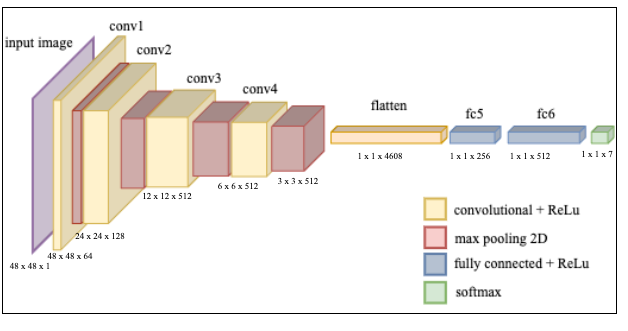

In [ ]:
no_of_classes = 7

inputs = layers.Input(shape=(48, 48, 1))
#1st CNN layer
layer = (Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))(inputs)
layer = (BatchNormalization())(layer)
layer = (Activation('relu'))(layer)
layer = (MaxPooling2D(pool_size = (2,2)))(layer)
layer = (Dropout(0.25))(layer)

#2nd CNN layer
layer = (Conv2D(128,(5,5),padding = 'same'))(layer)
layer = (BatchNormalization())(layer)
layer = (Activation('relu'))(layer)
layer = (MaxPooling2D(pool_size = (2,2)))(layer)
layer = (Dropout (0.25))(layer)

#3rd CNN layer
layer = (Conv2D(512,(3,3),padding = 'same'))(layer)
layer = (BatchNormalization())(layer)
layer = (Activation('relu'))(layer)
layer = (MaxPooling2D(pool_size = (2,2)))(layer)
layer = (Dropout (0.25))(layer)

#4th CNN layer
layer = (Conv2D(512,(3,3), padding='same'))(layer)
layer = (BatchNormalization())(layer)
layer = (Activation('relu'))(layer)
layer = (MaxPooling2D(pool_size=(2, 2)))(layer)
layer = (Dropout(0.25))(layer)
layer = (Flatten())(layer)

#Fully connected 1st layer
layer = (Dense(256))(layer)
layer = (BatchNormalization())(layer)
layer = (Activation('relu'))(layer)
layer = (Dropout(0.25))(layer)


# Fully connected layer 2nd layer
layer = (Dense(512))(layer)
layer = (BatchNormalization())(layer)
layer = (Activation('relu'))(layer)
layer = (Dropout(0.25))(layer)


outputs = Dense(no_of_classes, activation='softmax')(layer)

# create model
model = keras.Model(inputs=inputs, outputs= outputs)

# summarize model
model.summary()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0     

####**COMPILING AND TRAINING MODEL**

During the model compilation and training phase, the loss and metrics monitored were categorical cross entropy and categorical accuracy. Adam Optimization was used with a learning rate of 0.001. Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models. It combines the properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems. The model was trained in data with a batch size of 64 for a period of 50 epochs. For efficient training, early stopping was used to stop training when the delta value of monitored validation loss was less than zero for ten consecutive epochs (patience). A callback for reducing the learning rate by a factor of 0.02 was used to find global minima when the validation loss was observed to plateau.


In [ ]:
checkpoint = ModelCheckpoint("./custom_model.h5", monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=10,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 50

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['categorical_accuracy'])

history = model.fit(train_set,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                    epochs=epochs,
                    validation_data = val_set,
                    validation_steps = val_set.n//val_set.batch_size,
                    callbacks=callbacks_list
                    )

Epoch 1/50
358/358 [==============================] - ETA: 0s - loss: 1.9059 - categorical_accuracy: 0.2454
Epoch 1: val_categorical_accuracy improved from -inf to 0.27756, saving model to ./custom_model.h5
358/358 [==============================] - 30s 80ms/step - loss: 1.9059 - categorical_accuracy: 0.2454 - val_loss: 1.7626 - val_categorical_accuracy: 0.2776 - lr: 0.0010
Epoch 2/50
358/358 [==============================] - ETA: 0s - loss: 1.6795 - categorical_accuracy: 0.3423
Epoch 2: val_categorical_accuracy improved from 0.27756 to 0.42188, saving model to ./custom_model.h5
358/358 [==============================] - 24s 67ms/step - loss: 1.6795 - categorical_accuracy: 0.3423 - val_loss: 1.4856 - val_categorical_accuracy: 0.4219 - lr: 0.0010
Epoch 3/50
358/358 [==============================] - ETA: 0s - loss: 1.5015 - categorical_accuracy: 0.4178
Epoch 3: val_categorical_accuracy improved from 0.42188 to 0.47542, saving model to ./custom_model.h5
358/358 [========================

####**EPOCH VISUALIZATION**

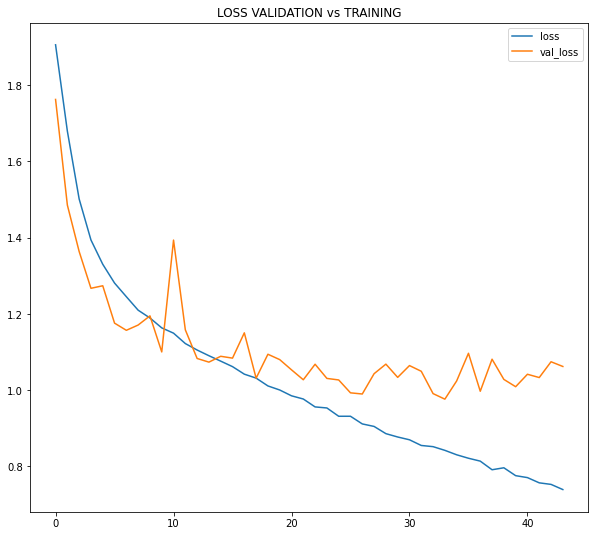

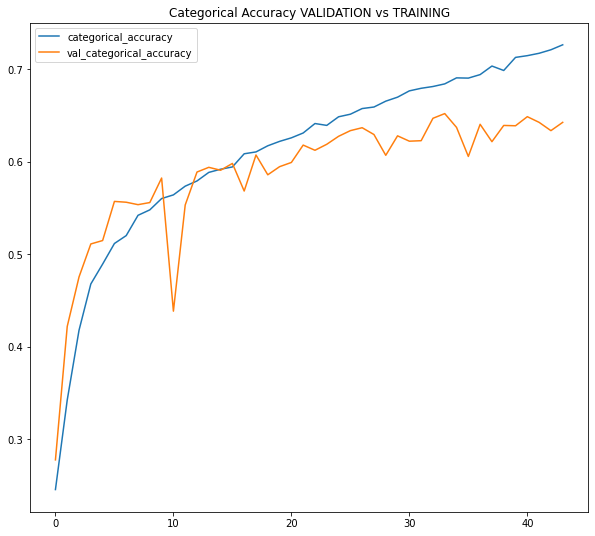

In [ ]:
# save history of the model in dataframe df_modelhis
graph =pd.DataFrame(model.history.history)

graph[['loss','val_loss']].plot(figsize = (10,9))
plt.title("LOSS VALIDATION vs TRAINING")
plt.show()

#Plotting accuracy
graph[['categorical_accuracy','val_categorical_accuracy']].plot(figsize = (10,9))
plt.title("Categorical Accuracy VALIDATION vs TRAINING")
plt.show()

####**MULTICLASS CONFUSION MATRIX**

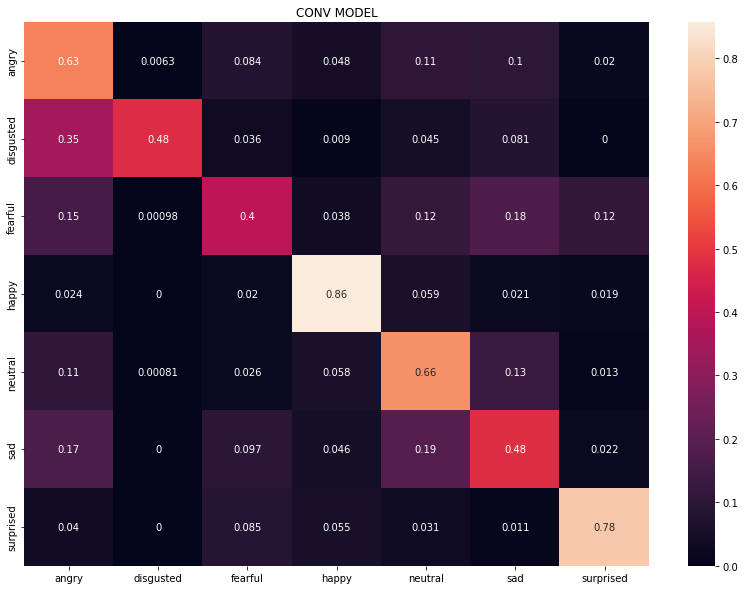

In [ ]:
reports = update_report('/content/custom_model.h5', 'CONV Model', test_set)

In [ ]:
reports.tail(1)

,model_name,recall,precision,f1,balanced_accuracy
0,CONV Model,0.647256,0.64927,0.643797,0.6118


##**VGG block ConvNet**

The VGG convolutional neural network architecture, named for the Visual Geometry Group at Oxford, achieved top results in the LSVRC-2014 computer vision competition.

The key innovation in this architecture was the definition and repetition of VGG-blocks. These are groups of convolutional layers that use small filters (e.g. 3×3 pixels) followed by a max pooling layer.

In this model, each VGG block consisted of a specified number of 
convolutional operations producing one among 64, 128 and 256 output filters. These convolutional operations used three-by-three filters and performed the same convolution. The combination of convolutional layers was followed by a max-pooling with two-by-two filters and with the same padding. Each VGG block was followed by a batch normalization layer and a dropout layer for regularisation. 

After flattening, two dense layers and a softmax layer were used to recognize face emotion. 

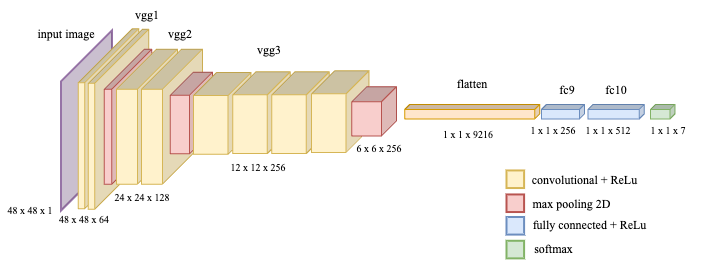


In [ ]:
no_of_classes = 7

In [ ]:
# function for creating a vgg block
def vgg_block(layer_in, n_filters, n_conv):
	# add convolutional layers
	for _ in range(n_conv):
		layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
	# add max pooling layer
	layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
	return layer_in

In [ ]:
 # define model input
inputs = layers.Input(shape=(48, 48, 1))
# add vgg module
layer = vgg_block(inputs, 64, 2)
layer = BatchNormalization()(layer)
layer = Dropout(0.25)(layer)
# add vgg module
layer = vgg_block(layer, 128, 2)
layer = BatchNormalization()(layer)
layer = Dropout(0.25)(layer)
# add vgg module
layer = vgg_block(layer, 256, 4)
layer = BatchNormalization()(layer)
layer = Dropout(0.25)(layer)

#Fully Connected
layer = Flatten()(layer)

#Fully connected 1st layer
layer = Dense(256)(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.25)(layer)

#Fully connected 2nd layer
layer = Dense(512)(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.25)(layer)

outputs = Dense(no_of_classes, activation='softmax')(layer)

# create model
model = keras.Model(inputs=inputs, outputs= outputs)
# summarize model
model.summary()
# plot model architecture

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0   

####**COMPILING AND TRAINING MODEL**

During the model compilation and training phase, the loss and metrics monitored were categorical cross entropy and categorical accuracy. Adam Optimization was used with a learning rate of 0.001. Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models. It combines the properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems. The model was trained in data with a batch size of 64 for a period of 50 epochs. For efficient training, early stopping was used to stop training when the delta value of monitored validation loss was less than zero for ten consecutive epochs (patience). A callback for reducing the learning rate by a factor of 0.02 was used to find global minima when the validation loss was observed to plateau.


In [ ]:
checkpoint = ModelCheckpoint("./vgg_model.h5", monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=10,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 50

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['categorical_accuracy'])

history = model.fit(train_set,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                    epochs=epochs,
                    validation_data = val_set,
                    validation_steps = val_set.n//val_set.batch_size,
                    callbacks=callbacks_list
                    )

Epoch 1/50
358/358 [==============================] - ETA: 0s - loss: 1.9539 - categorical_accuracy: 0.2194
Epoch 1: val_categorical_accuracy improved from -inf to 0.23543, saving model to ./vgg_model.h5
358/358 [==============================] - 30s 80ms/step - loss: 1.9539 - categorical_accuracy: 0.2194 - val_loss: 1.8108 - val_categorical_accuracy: 0.2354 - lr: 0.0010
Epoch 2/50
358/358 [==============================] - ETA: 0s - loss: 1.7566 - categorical_accuracy: 0.3024
Epoch 2: val_categorical_accuracy improved from 0.23543 to 0.29249, saving model to ./vgg_model.h5
358/358 [==============================] - 29s 82ms/step - loss: 1.7566 - categorical_accuracy: 0.3024 - val_loss: 1.7876 - val_categorical_accuracy: 0.2925 - lr: 0.0010
Epoch 3/50
358/358 [==============================] - ETA: 0s - loss: 1.5783 - categorical_accuracy: 0.3852
Epoch 3: val_categorical_accuracy improved from 0.29249 to 0.41327, saving model to ./vgg_model.h5
358/358 [==============================] -

####**EPOCH VISUALIZATION**

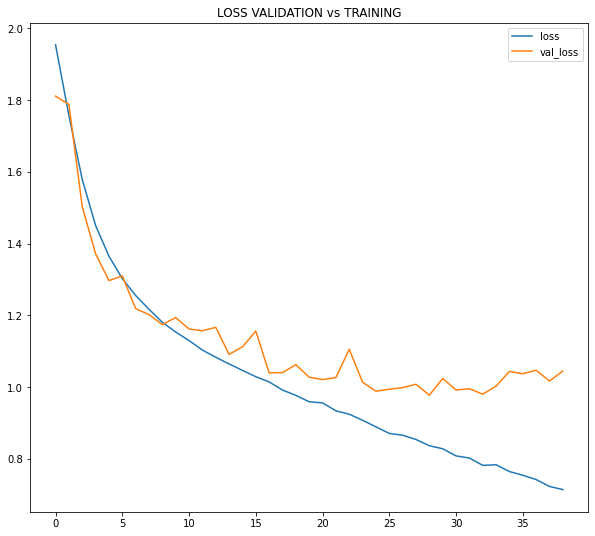

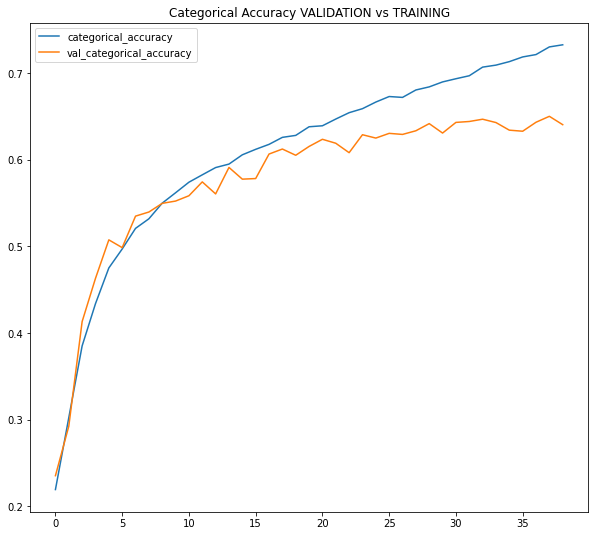

In [ ]:
# save history of the model in dataframe df_modelhis
graph =pd.DataFrame(model.history.history)

graph[['loss','val_loss']].plot(figsize = (10,9))
plt.title("LOSS VALIDATION vs TRAINING")
plt.show()

#Plotting accuracy
graph[['categorical_accuracy','val_categorical_accuracy']].plot(figsize = (10,9))
plt.title("Categorical Accuracy VALIDATION vs TRAINING")
plt.show()

####**MULTICLASS CONFUSION MATRIX**

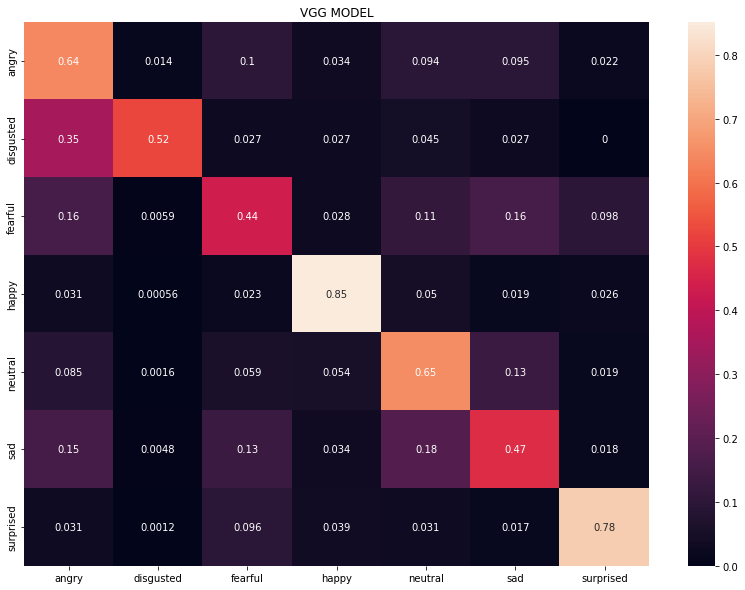

In [ ]:
reports = update_report('/content/vgg_model.h5', 'VGG Model', test_set)

In [ ]:
reports.tail(1)

,model_name,recall,precision,f1,balanced_accuracy
1,VGG Model,0.650878,0.652719,0.649514,0.622645


#**Inception Block ConvNet**

The inception module was described and used in the GoogLeNet model. Like the VGG model, the GoogLeNet model achieved competitive results in the 2014 ILSVRC challenge.

The key innovation of the inception model is the use of a block of parallel convolutional layers with different sized filters (e.g. 1×1, 3×3, 5×5) and 3×3 max pooling layer, the results of which are then concatenated.

 This is a very simple and powerful architectural unit that allows the model to learn not only parallel filters of the same size but parallel filters of differing sizes, allowing learning at multiple scales.

After flattening the inception block output, a dense layer  and a softmax layer are implemented.

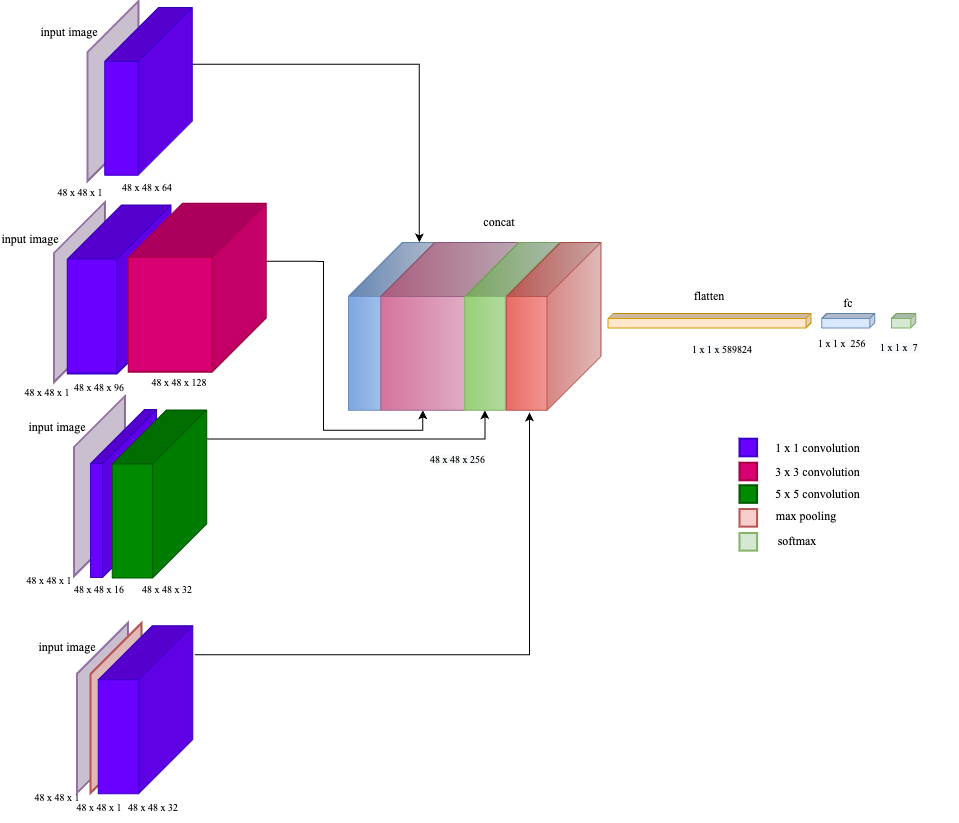

In [ ]:
from tensorflow.keras.layers import concatenate

In [ ]:
# function for creating a projected inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 5x5 conv
	conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out
 
# define model input
visible = layers.Input(shape=(48, 48, 1))

# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)

#Fully Connected
layer = Flatten()(layer)

#Fully connected 1st layer
layer = Dense(256)(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.25)(layer)

outputs = Dense(no_of_classes, activation='softmax')(layer)

# create model
model = keras.Model(inputs=visible, outputs=outputs)
# summarize model
model.summary()
# plot model architecture

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_49 (Conv2D)             (None, 48, 48, 96)   192         ['input_8[0][0]']                
                                                                                                  
 conv2d_51 (Conv2D)             (None, 48, 48, 16)   32          ['input_8[0][0]']                
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 48, 48, 1)   0           ['input_8[0][0]']                
 )                                                                                          

####**COMPILING AND TRAINING MODEL**

During the model compilation and training phase, the loss and metrics monitored were categorical cross entropy and categorical accuracy. Adam Optimization was used with a learning rate of 0.001. Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models. It combines the properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems. The model was trained in data with a batch size of 64 for a period of 60 epochs. For efficient training, early stopping was used to stop training when the delta value of monitored validation loss was less than zero for ten consecutive epochs (patience). A callback for reducing the learning rate by a factor of 0.02 was used to find global minima when the validation loss was observed to plateau.


In [ ]:
checkpoint = ModelCheckpoint("./inception_model.h5",  monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=10,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 60

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['categorical_accuracy'])

history = model.fit(train_set,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                    epochs=epochs,
                    validation_data = val_set,
                    validation_steps = val_set.n//val_set.batch_size,
                    callbacks=callbacks_list
                    )

Epoch 1/60


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


358/358 [==============================] - ETA: 0s - loss: 1.9131 - categorical_accuracy: 0.2676
Epoch 1: val_categorical_accuracy improved from -inf to 0.30916, saving model to ./inception_model.h5
358/358 [==============================] - 42s 113ms/step - loss: 1.9131 - categorical_accuracy: 0.2676 - val_loss: 1.7276 - val_categorical_accuracy: 0.3092 - lr: 0.0010
Epoch 2/60
358/358 [==============================] - ETA: 0s - loss: 1.7279 - categorical_accuracy: 0.3219
Epoch 2: val_categorical_accuracy improved from 0.30916 to 0.34533, saving model to ./inception_model.h5
358/358 [==============================] - 39s 108ms/step - loss: 1.7279 - categorical_accuracy: 0.3219 - val_loss: 1.7485 - val_categorical_accuracy: 0.3453 - lr: 0.0010
Epoch 3/60
358/358 [==============================] - ETA: 0s - loss: 1.6591 - categorical_accuracy: 0.3485
Epoch 3: val_categorical_accuracy improved from 0.34533 to 0.37939, saving model to ./inception_model.h5
358/358 [========================

####**EPOCH VISUALIZATION**

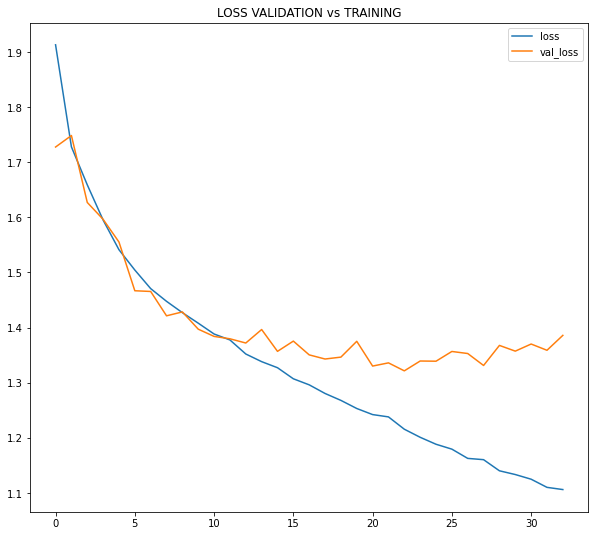

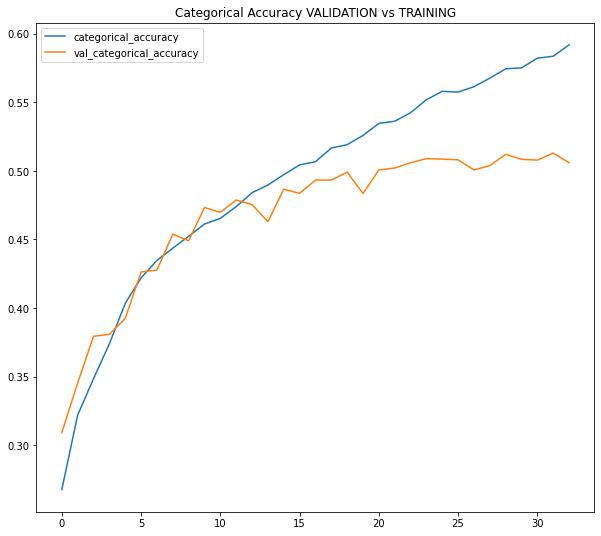

In [ ]:
# save history of the model in dataframe df_modelhis
graph =pd.DataFrame(model.history.history)

graph[['loss','val_loss']].plot(figsize = (10,9))
plt.title("LOSS VALIDATION vs TRAINING")
plt.show()

#Plotting accuracy
graph[['categorical_accuracy','val_categorical_accuracy']].plot(figsize = (10,9))
plt.title("Categorical Accuracy VALIDATION vs TRAINING")
plt.show()

####**MULTICLASS CONFUSION MATRIX**

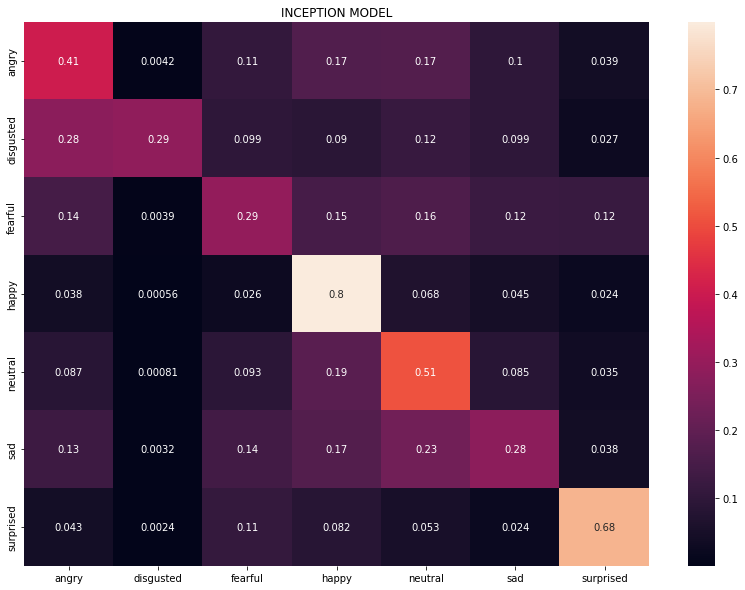

In [ ]:
reports = update_report('/content/inception_model.h5', 'INCEPTION Model', test_set)

In [ ]:
reports.tail(1)

,model_name,recall,precision,f1,balanced_accuracy
2,INCEPTION Model,0.513931,0.500428,0.499383,0.466222


In [ ]:
from google.colab import files
files.download('/content/inception_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#OBSERVATIONS

In [ ]:
reports

,model_name,recall,precision,f1,balanced_accuracy
0,CONV Model,0.647256,0.649270,0.643797,0.611800
1,VGG Model,0.650878,0.652719,0.649514,0.622645
2,INCEPTION Model,0.513931,0.500428,0.499383,0.466222


##**Transfer Learning:**

In order to perform transfer learning, the inputs need to have three channels. Therefore, the input is being converted from black and white to color 

###**CHANGING INPUT DATA FORMAT**

In [ ]:
train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


val_set = datagen_val.flow_from_directory(folder_path+ 'val',
                                              target_size = (picture_size,picture_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)



test_set = datagen_val.flow_from_directory('/content/test',
                                              target_size = (picture_size,picture_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 22965 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


####**SHAPE OF IMAGE IN TRAIN, TEST and VAL dataset**

In [ ]:
for dataset in   [train_set, val_set, test_set]:
  for data_batch, labels_batch in dataset:
      print("\ndata batch shape:", data_batch.shape)
      print("labels batch shape:", labels_batch.shape)
      break


data batch shape: (64, 48, 48, 3)
labels batch shape: (64, 7)

data batch shape: (64, 48, 48, 3)
labels batch shape: (64, 7)

data batch shape: (64, 48, 48, 3)
labels batch shape: (64, 7)


##**RESNET-50**

The Residual Network, or ResNet, architecture for convolutional neural networks, proposed by Kaiming, achieved notable success on the 2015 version of the ILSVRC challenge.

A key innovation in the ResNet architecture was the residual module. 

The residual module, specifically the identity residual model, is a block of two convolutional layers with the same number of filters and a small filter size where the output of the second layer is added with the input to the first convolutional layer. 

The input to the module is added to the output of the module and is called a shortcut connection 

Transfer learning was implemented using the ImageNet weights for the ResNet-50 model and was trained after freezing the penultimate layers.

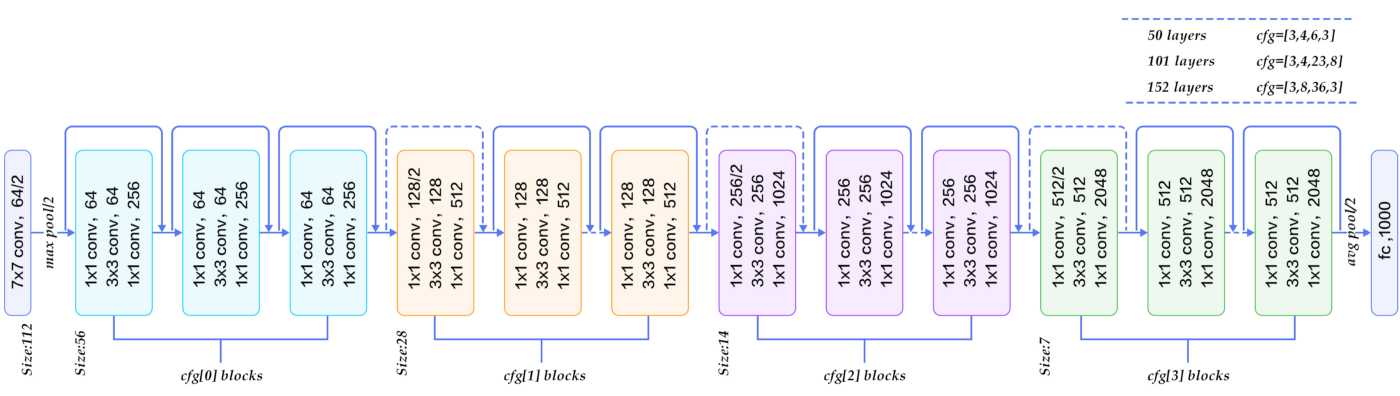

In [ ]:
#using pretrained model, RESNET50 architecture
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
# creating a base model using resnet 
# and loading the pretrained weights 
base_model = ResNet50(input_shape=(48,48,3),include_top = False, weights = 'imagenet')
base_model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                          

####**FREEZING LAYERS**

In [ ]:
# making all the layers except last 4 layers non trainable 
for layer in base_model.layers[:-4]:
    layer.trainable = False

####**TRAINING**

In [ ]:

# define model input
visible = keras.layers.Input(shape=(48, 48, 3))

layer = (base_model)(visible)
layer = (Flatten())(layer)

#Fully connected 1st layer
layer = (Dense(512,kernel_initializer='he_normal'))(layer)
layer = (BatchNormalization())(layer)
layer = (Activation('relu'))(layer)
layer = (Dropout(0.25))(layer)


# Fully connected layer 2nd layer
layer = (Dense(256,kernel_initializer='he_normal'))(layer)
layer = (BatchNormalization())(layer)
layer = (Activation('relu'))(layer)
layer = (Dropout(0.25))(layer)

#output layer
outputs = (Dense(7, activation='softmax'))(layer)

# create model
model = keras.Model(inputs=visible, outputs=outputs)
# summarize model
model.summary()
# plot model architectur


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               4194816   
                                                                 
 batch_normalization_14 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 512)               0         
                                                           

####**COMPILING AND TRAINING MODEL**
During the model compilation and training phase, the loss and metrics monitored were categorical cross entropy and categorical accuracy. Adam Optimization was used with a learning rate of 0.001. Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models. It combines the properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems. The model was trained in data with a batch size of 64 for a period of 50 epochs. For efficient training, early stopping was used to stop training when the delta value of monitored validation loss was less than zero for ten consecutive epochs (patience). A callback for reducing the learning rate by a factor of 0.02 was used to find global minima when the validation loss was observed to plateau.


In [ ]:
checkpoint = ModelCheckpoint("./tl_resnet_model.h5",  monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=10,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 50

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['categorical_accuracy'])

history = model.fit(train_set,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                    epochs=epochs,
                    validation_data = val_set,
                    validation_steps = val_set.n//val_set.batch_size,
                    callbacks=callbacks_list
                    )

Epoch 1/50
358/358 [==============================] - ETA: 0s - loss: 1.8815 - categorical_accuracy: 0.2468
Epoch 1: val_categorical_accuracy improved from -inf to 0.27616, saving model to ./tl_resnet_model.h5
358/358 [==============================] - 53s 132ms/step - loss: 1.8815 - categorical_accuracy: 0.2468 - val_loss: 1.8006 - val_categorical_accuracy: 0.2762 - lr: 0.0010
Epoch 2/50
358/358 [==============================] - ETA: 0s - loss: 1.7671 - categorical_accuracy: 0.2903
Epoch 2: val_categorical_accuracy improved from 0.27616 to 0.27756, saving model to ./tl_resnet_model.h5
358/358 [==============================] - 43s 121ms/step - loss: 1.7671 - categorical_accuracy: 0.2903 - val_loss: 1.8442 - val_categorical_accuracy: 0.2776 - lr: 0.0010
Epoch 3/50
358/358 [==============================] - ETA: 0s - loss: 1.7292 - categorical_accuracy: 0.3064
Epoch 3: val_categorical_accuracy did not improve from 0.27756
358/358 [==============================] - 35s 97ms/step - loss:

####**EPOCH VISUALIZATION**

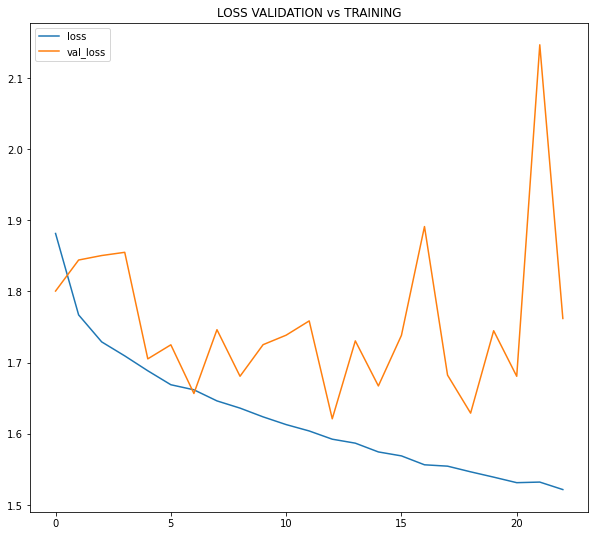

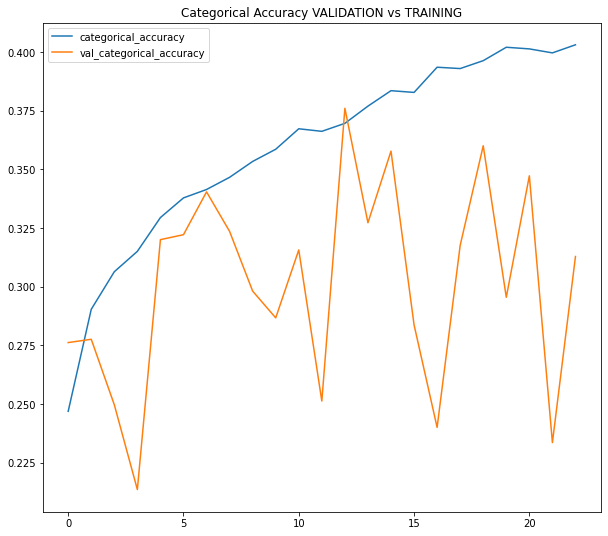

In [ ]:
# save history of the model in dataframe df_modelhis
graph =pd.DataFrame(model.history.history)

graph[['loss','val_loss']].plot(figsize = (10,9))
plt.title("LOSS VALIDATION vs TRAINING")
plt.show()

#Plotting accuracy
graph[['categorical_accuracy','val_categorical_accuracy']].plot(figsize = (10,9))
plt.title("Categorical Accuracy VALIDATION vs TRAINING")
plt.show()

####**MULTICLASS CONFUSION MATRIX**

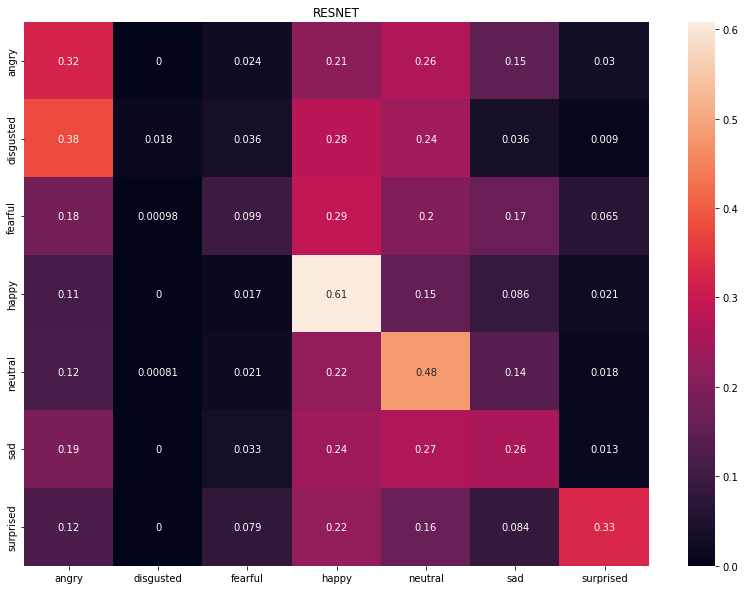

In [ ]:
reports = update_report('/content/tl_resnet_model.h5', 'TF RESNET', test_set)

In [ ]:
reports.tail(1)

,model_name,recall,precision,f1,balanced_accuracy
4,RESNET,0.373502,0.384801,0.354616,0.302427


## **VGG16**

VGG-16 is a convolutional neural network that is 16 layers deep. 

With the help of transfer learning, it is used to load a pre-trained version of the network trained on more than a million images from the ImageNet database. The pre-trained network can classify images into thousand object categories. As a result, the network has learned rich feature representations for a wide range of images.

There are thirteen convolutional layers, five Max Pooling layers, and three Dense layers which sum up to 21 layers in the VGG-16 model of which there are sixteen learnable layers.

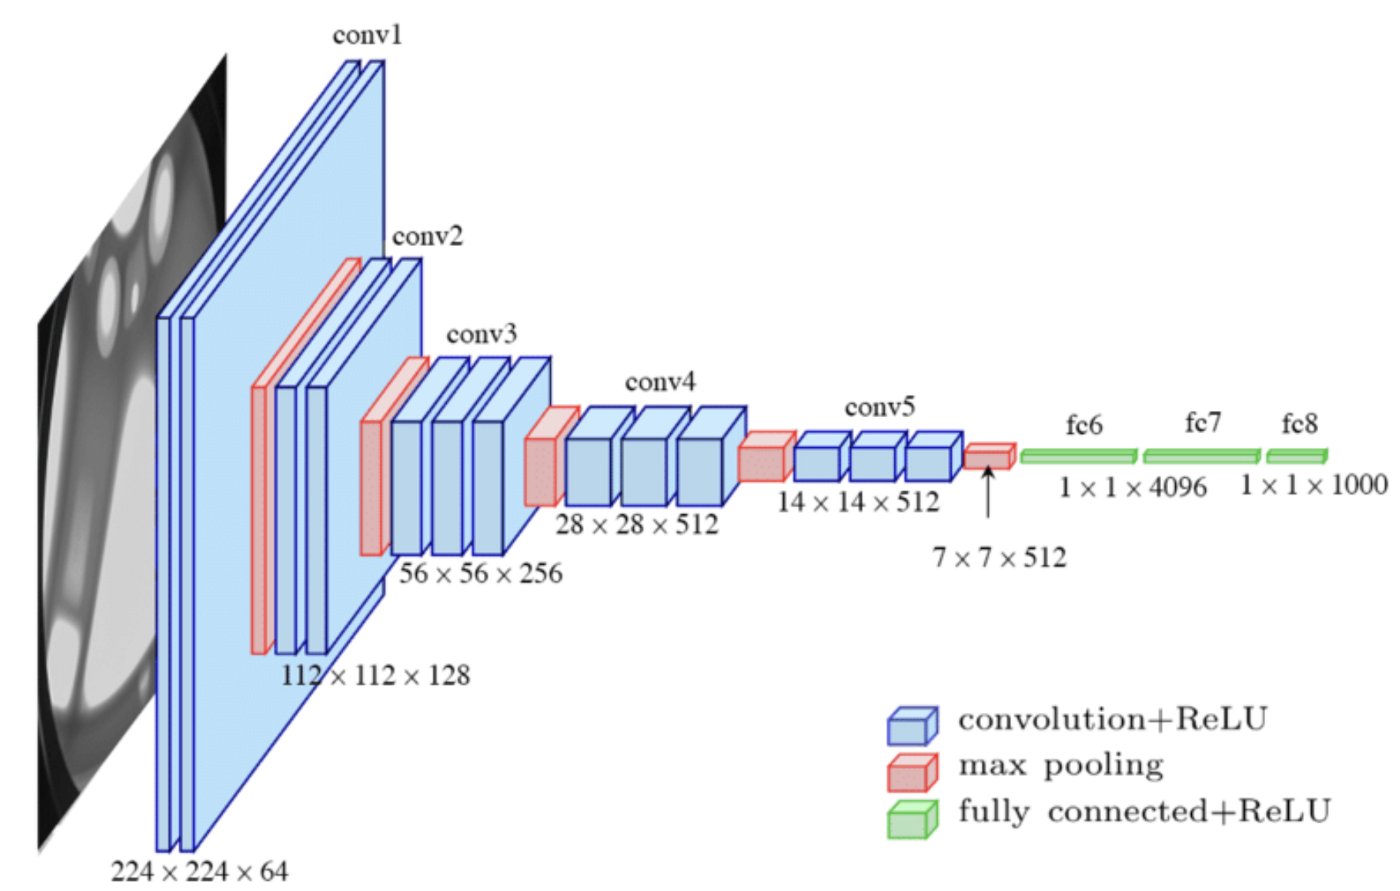

As the VGG-16 model, accepts only three channel images, the grayscale input images were converted into three channel images. The top layer of the model was omitted to suit the dataset specifications and all the layers but the last four were frozen with ImageNet weights.

The model was followed by two fully connected ReLu layers and a softmax layer for emotion recognition




In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
# creating a base model using resnet 
# and loading the pretrained weights 

base_model = VGG16(input_shape=(48,48,3),include_top = False, weights = 'imagenet')
base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

####**FREEZING LAYERS**

In [ ]:
# making all the layers except last 4 layers non trainable 
for layer in base_model.layers[:-4]:
    layer.trainable = False

####**CREATING MODEL**

In [ ]:

# define model input
visible = keras.layers.Input(shape=(48, 48, 3))

layer = (base_model)(visible)
layer = (Dropout(0.2))(layer)
layer = (Flatten())(layer)
layer = (BatchNormalization())(layer)

#Fully connected 1st layer
layer = (Dense(512,kernel_initializer='he_normal'))(layer)
layer = (BatchNormalization())(layer)
layer = (Activation('relu'))(layer)
layer = (Dropout(0.25))(layer)


# Fully connected layer 2nd layer
layer = (Dense(256,kernel_initializer='he_normal'))(layer)
layer = (BatchNormalization())(layer)
layer = (Activation('relu'))(layer)
layer = (Dropout(0.25))(layer)

#output layer
outputs = (Dense(7, activation='softmax'))(layer)

# create model
model = keras.Model(inputs=visible, outputs=outputs)
# summarize model
model.summary()
# plot model architectur


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout_16 (Dropout)        (None, 1, 1, 512)         0         
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_16 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                           

####**COMPILING AND TRAINING**

During the model compilation and training phase, the loss and metrics monitored were categorical cross entropy and categorical accuracy. Adam Optimization was used with a learning rate of 0.001. Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models. It combines the properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems. The model was trained in data with a batch size of 64 for a period of 60 epochs. For efficient training, early stopping was used to stop training when the delta value of monitored validation loss was less than zero for ten consecutive epochs (patience). A callback for reducing the learning rate by a factor of 0.02 was used to find global minima when the validation loss was observed to plateau.


In [ ]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./tf_VGG16_model.h5",  monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=10,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 60

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['categorical_accuracy'])

history = model.fit(train_set,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                    epochs=epochs,
                    validation_data = val_set,
                    validation_steps = val_set.n//val_set.batch_size,
                    callbacks=callbacks_list
                    )

Epoch 1/60


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


358/358 [==============================] - ETA: 0s - loss: 1.8683 - categorical_accuracy: 0.2701
Epoch 1: val_categorical_accuracy improved from -inf to 0.21682, saving model to ./tf_VGG16_model.h5
358/358 [==============================] - 41s 109ms/step - loss: 1.8683 - categorical_accuracy: 0.2701 - val_loss: 2.6818 - val_categorical_accuracy: 0.2168 - lr: 0.0010
Epoch 2/60
358/358 [==============================] - ETA: 0s - loss: 1.6036 - categorical_accuracy: 0.3710
Epoch 2: val_categorical_accuracy improved from 0.21682 to 0.37008, saving model to ./tf_VGG16_model.h5
358/358 [==============================] - 34s 95ms/step - loss: 1.6036 - categorical_accuracy: 0.3710 - val_loss: 1.5820 - val_categorical_accuracy: 0.3701 - lr: 0.0010
Epoch 3/60
358/358 [==============================] - ETA: 0s - loss: 1.5415 - categorical_accuracy: 0.4032
Epoch 3: val_categorical_accuracy did not improve from 0.37008
358/358 [==============================] - 35s 96ms/step - loss: 1.5415 - cate

####**EPOCH VISUALIZATION**

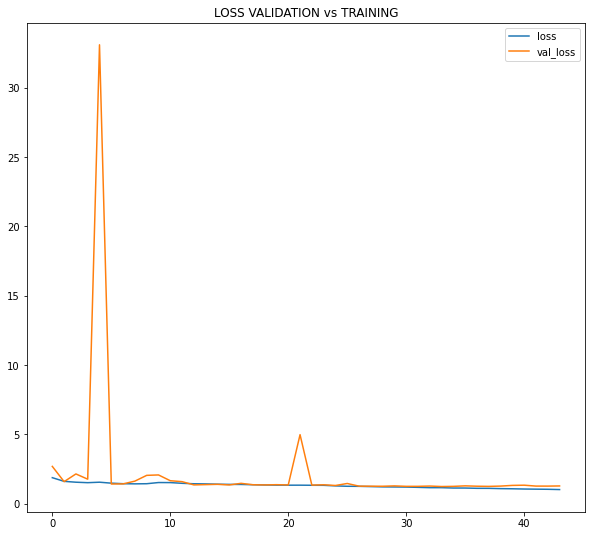

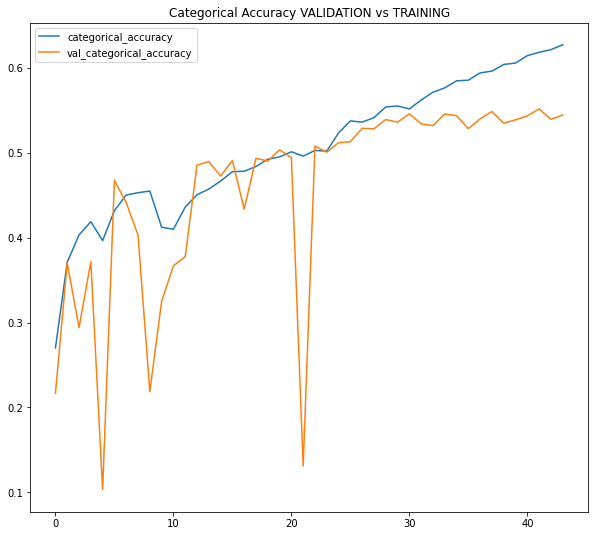

In [ ]:
# save history of the model in dataframe df_modelhis
graph =pd.DataFrame(model.history.history)

graph[['loss','val_loss']].plot(figsize = (10,9))
plt.title("LOSS VALIDATION vs TRAINING")
plt.show()

#Plotting accuracy
graph[['categorical_accuracy','val_categorical_accuracy']].plot(figsize = (10,9))
plt.title("Categorical Accuracy VALIDATION vs TRAINING")
plt.show()

####**MULTICLASS CONFUSION MATRIX**

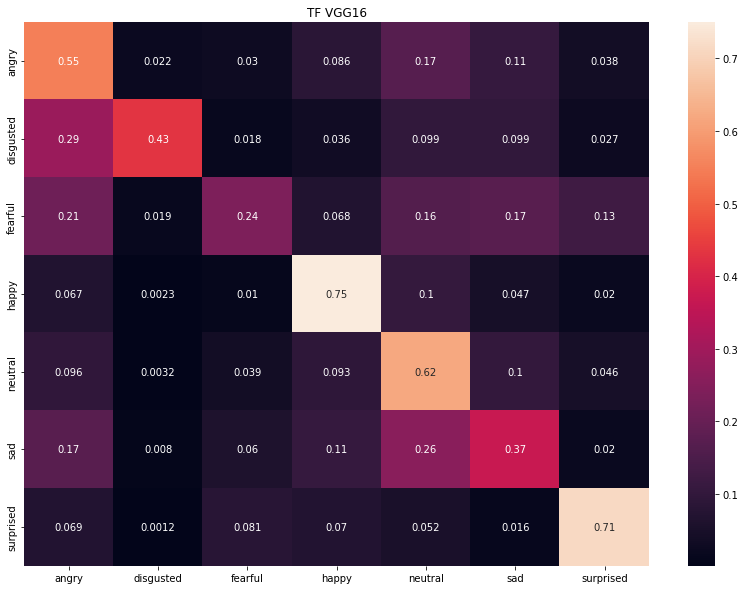

In [ ]:
reports = update_report('/content/tf_VGG16_model.h5', 'TF VGG16', test_set)

In [ ]:
reports.tail(1)

,model_name,recall,precision,f1,balanced_accuracy
5,TF VGG16,0.552661,0.556654,0.543347,0.524652


#**FINAL REPORT**

During the course of the project, five models were built and compared to effectively identify student emotions using the FER-2013 dataset. The best classifying model, ConvNet with VGG blocks,  had an F1 score of 65 per cent and a balanced accuracy score of 62.2 per cent.


In [ ]:
reports

,model_name,recall,precision,f1,balanced_accuracy
0,CONV Model,0.647256,0.649270,0.643797,0.611800
1,VGG Model,0.650878,0.652719,0.649514,0.622645
2,INCEPTION Model,0.513931,0.500428,0.499383,0.466222
4,RESNET,0.373502,0.384801,0.354616,0.302427
5,TF VGG16,0.552661,0.556654,0.543347,0.524652


#**CONCLUSIONS**

>* **During the course of the project, five models were built and compared to effectively identify student emotions using the FER-2013 dataset.** 

> * **The best classifying model, ConvNet with VGG blocks,  had an F1 score of 65 per cent and a balanced accuracy score of 62.2 per cent.**

>* **It was observed from the confusion matrix  that the model could effectively classify emotions like Happy, Angry, Surprised and Neutral while emotions like Fear and Disgusted were classified with some difficulty.** 

>* **However, this issue only posed mild concern as those emotions were considered irrelevant in the context of digital learning.**

>* **The model was used to create a web application to access the model and was deployed as a  model on the cloud as an end-to-end solution.**

>* **Further improvements that can be sought to be made are the inclusion of images with different levels of illumination and using sophisticated tools to make the web application lighter to suit the parallel processing of multiple video snippets for a real-life classroom environment.**
